# Clustering Assignment: K-Means, Hierarchical, and DBSCAN
  

This notebook covers:
1. Data loading and preview  
2. Preprocessing: missing values, outlier handling (IQR capping), scaling  
3. EDA: distributions, box plots, correlations  
4. Clustering implementations: **K-Means**, **Hierarchical (Agglomerative)**, **DBSCAN**  
5. Parameter exploration: Elbow method, linkage types, DBSCAN grid search  
6. Evaluation: **Silhouette score** (where applicable)  
7. Cluster visualization in PCA space and **cluster profiling**  



In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import iqr

# Settings
pd.set_option('display.max_columns', None)
%matplotlib inline


## 1) Load the dataset

In [2]:

# Adjust the path if needed
file_path = 'EastWestAirlines.xlsx'

# Inspect sheets and load
xls = pd.ExcelFile(file_path)
print("Sheets:", xls.sheet_names)
df = pd.read_excel(file_path, sheet_name='data')
df.head()


Sheets: ['Description', 'data']


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


## 2) Basic information & missing values

In [3]:

print(df.shape)
display(df.describe(include='all'))
display(df.isna().sum())


(3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

### Feature selection

In [4]:

# Exclude identifier/label-like columns from clustering features
exclude_cols = ['ID#', 'Award?']
feature_cols = [c for c in df.columns if c not in exclude_cols]
X_raw = df[feature_cols].copy()
y_award = df['Award?'] if 'Award?' in df.columns else None

X_raw.head()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,28143,0,1,1,1,174,1,0,0,7000
1,19244,0,1,1,1,215,2,0,0,6968
2,41354,0,1,1,1,4123,4,0,0,7034
3,14776,0,1,1,1,500,1,0,0,6952
4,97752,0,4,1,1,43300,26,2077,4,6935


## 3) Preprocessing

### 3.1 Handle missing values (median imputation)

In [5]:

# Median imputation for any missing numeric values
X_imputed = X_raw.copy()
for col in X_imputed.columns:
    if X_imputed[col].isna().any():
        X_imputed[col].fillna(X_imputed[col].median(), inplace=True)

X_imputed.isna().sum()


Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
dtype: int64

### 3.2 Outlier handling using IQR capping

In [6]:

def iqr_cap(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_value = q3 - q1
    lower = q1 - factor * iqr_value
    upper = q3 + factor * iqr_value
    return np.clip(series, lower, upper), (lower, upper)

X_capped = pd.DataFrame(index=X_imputed.index)
caps = {}
for col in X_imputed.columns:
    X_capped[col], caps[col] = iqr_cap(X_imputed[col].astype(float), factor=1.5)

caps, X_capped.head()


({'Balance': (np.float64(-92287.25), np.float64(203218.75)),
  'Qual_miles': (np.float64(0.0), np.float64(0.0)),
  'cc1_miles': (np.float64(-2.0), np.float64(6.0)),
  'cc2_miles': (np.float64(1.0), np.float64(1.0)),
  'cc3_miles': (np.float64(1.0), np.float64(1.0)),
  'Bonus_miles': (np.float64(-32575.75), np.float64(57626.25)),
  'Bonus_trans': (np.float64(-18.0), np.float64(38.0)),
  'Flight_miles_12mo': (np.float64(-466.5), np.float64(777.5)),
  'Flight_trans_12': (np.float64(-1.5), np.float64(2.5)),
  'Days_since_enroll': (np.float64(-2860.75), np.float64(10981.25))},
    Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
 0  28143.0         0.0        1.0        1.0        1.0        174.0   
 1  19244.0         0.0        1.0        1.0        1.0        215.0   
 2  41354.0         0.0        1.0        1.0        1.0       4123.0   
 3  14776.0         0.0        1.0        1.0        1.0        500.0   
 4  97752.0         0.0        4.0        1.0        1.0

### 3.3 Feature scaling (StandardScaler)

In [7]:

scaler = StandardScaler()
X = scaler.fit_transform(X_capped.values)
X = pd.DataFrame(X, columns=X_capped.columns, index=X_capped.index)
X.head()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,-0.607258,0.0,-0.769578,0.0,0.0,-0.843091,-1.148854,-0.604313,-0.626143,1.395454
1,-0.758947,0.0,-0.769578,0.0,0.0,-0.840822,-1.039133,-0.604313,-0.626143,1.379957
2,-0.382070,0.0,-0.769578,0.0,0.0,-0.624581,-0.819689,-0.604313,-0.626143,1.411920
3,-0.835106,0.0,-0.769578,0.0,0.0,-0.825052,-1.148854,-0.604313,-0.626143,1.372208
4,0.579265,0.0,1.409471,0.0,0.0,1.543191,1.594189,2.034489,2.020176,1.363975


## 4) EDA

### 4.1 Distributions (Histograms) — one per feature

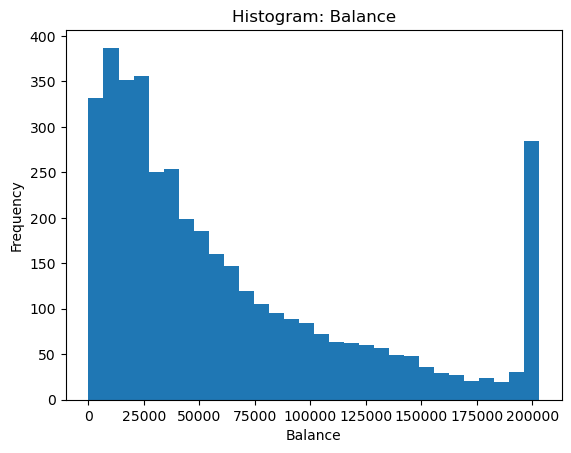

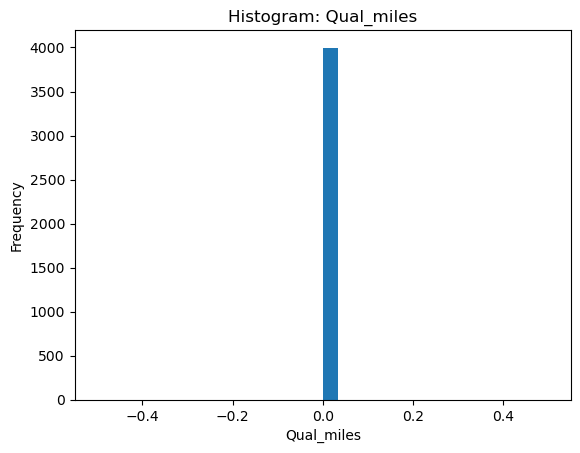

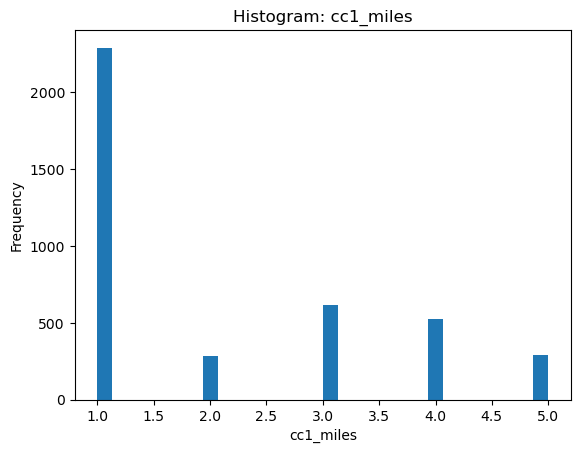

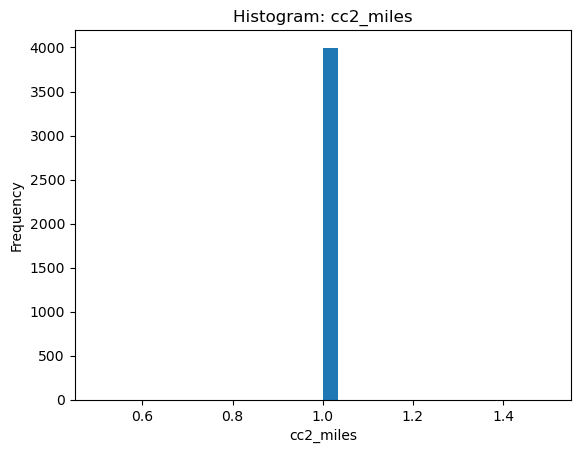

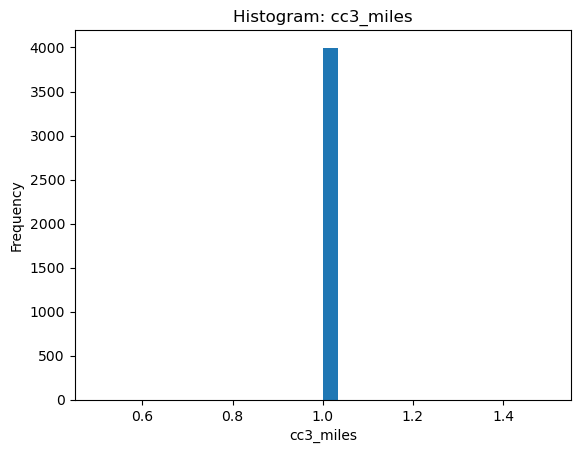

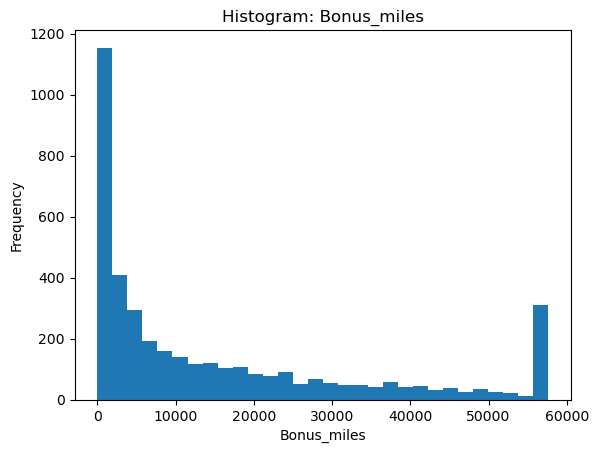

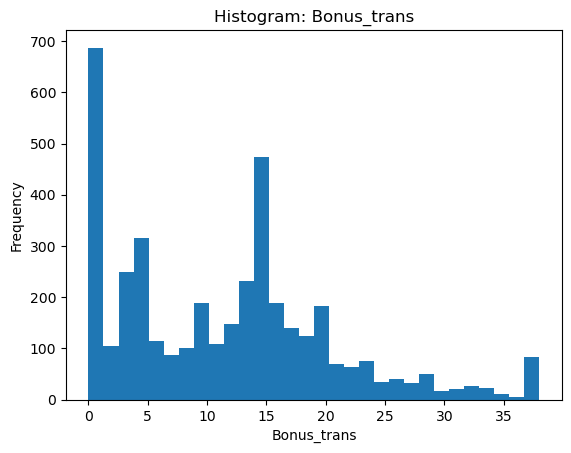

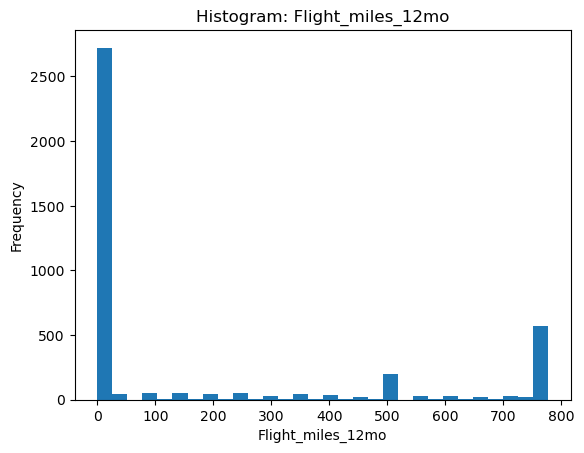

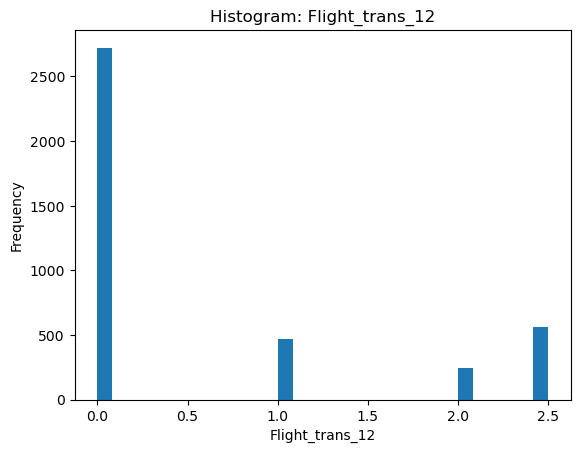

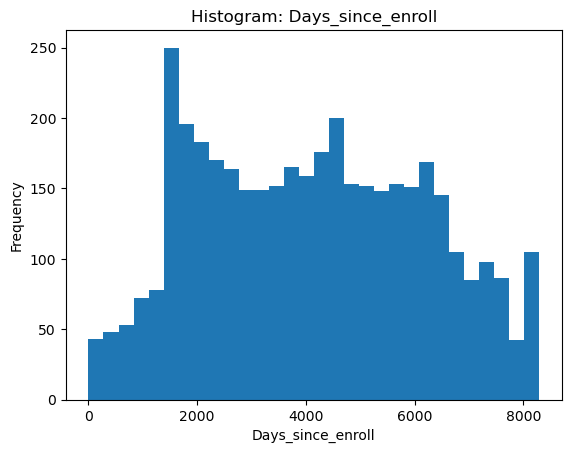

In [8]:

for col in X_capped.columns:
    plt.figure()
    plt.hist(X_capped[col].values, bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


### 4.2 Box Plots — one per feature

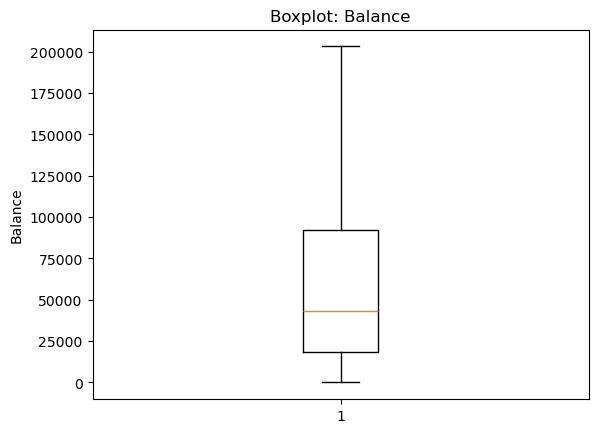

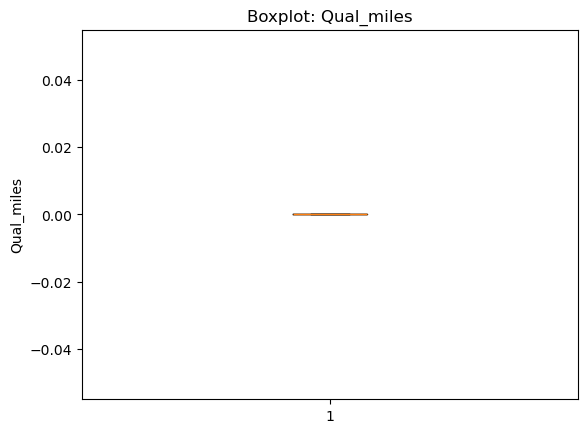

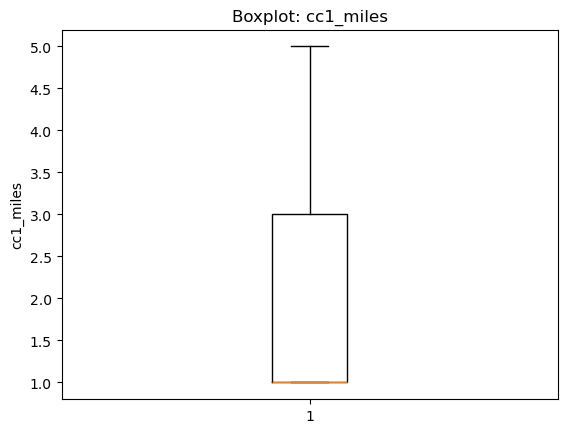

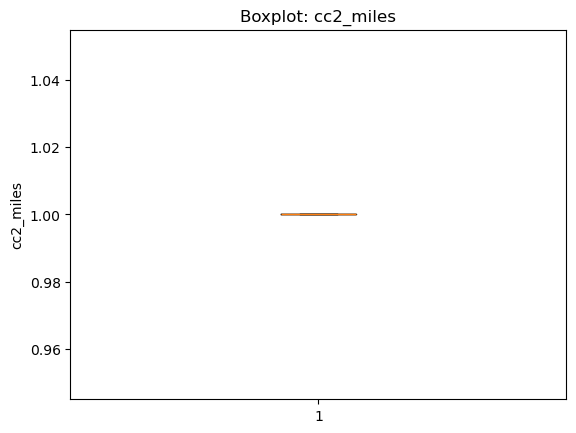

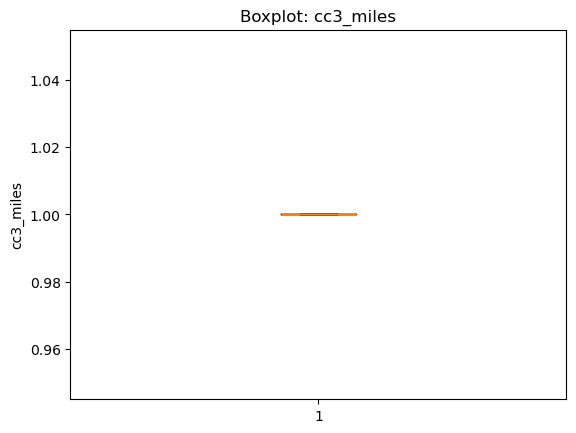

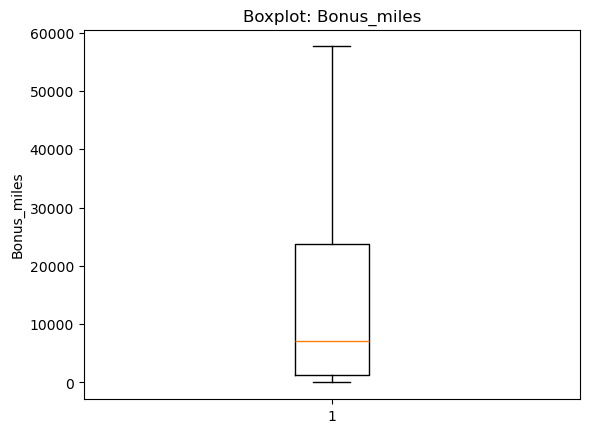

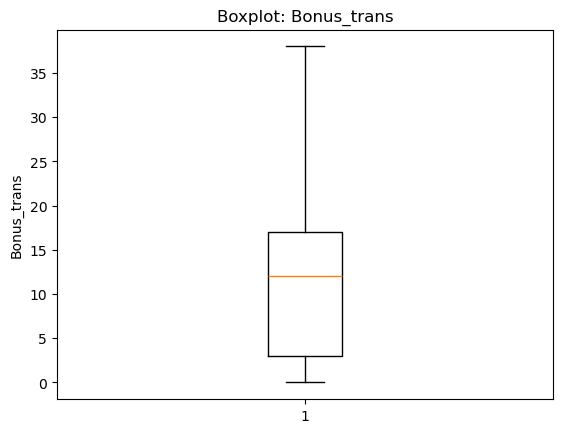

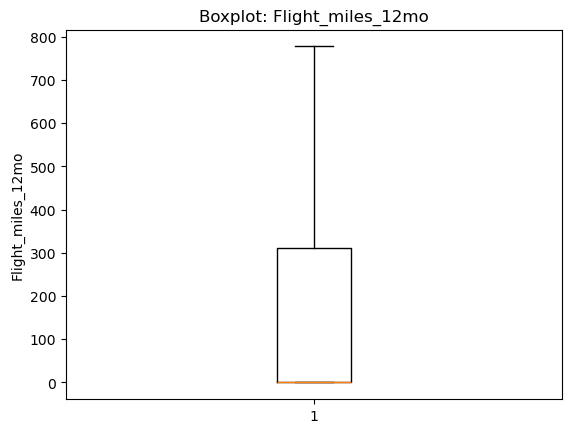

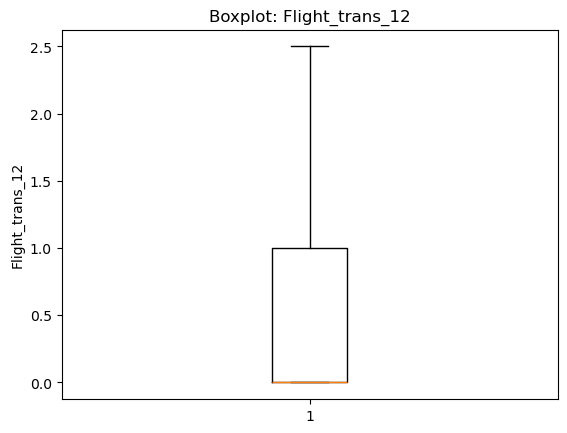

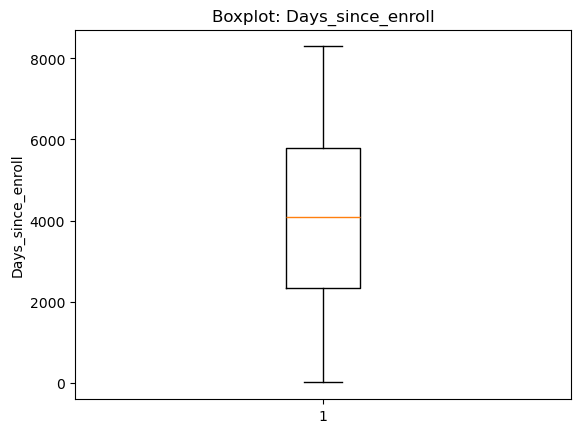

In [9]:

for col in X_capped.columns:
    plt.figure()
    plt.boxplot(X_capped[col].values, vert=True)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.show()


### 4.3 Correlation Heatmap

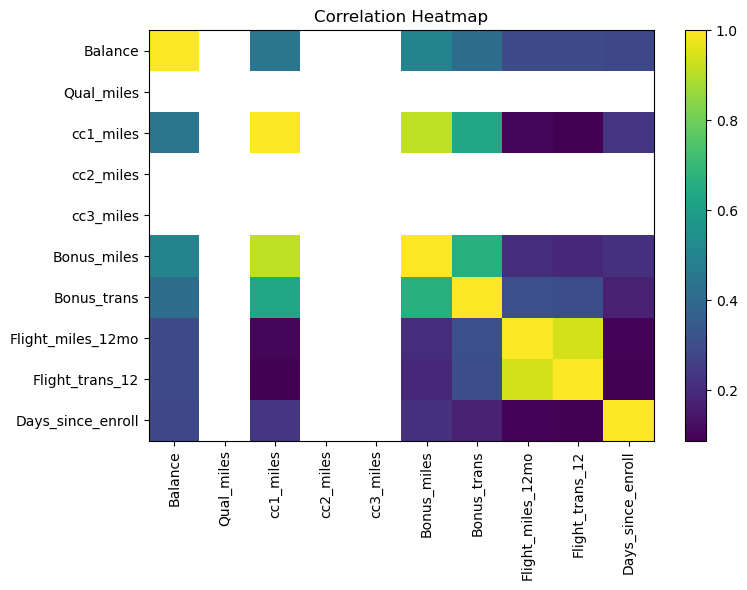

In [10]:

corr = X_capped.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## 5) PCA (2D) for visualization

In [11]:

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)
print("Explained variance ratio (2D):", pca.explained_variance_ratio_)


Explained variance ratio (2D): [0.46098447 0.24322009]


## 6) K-Means Clustering

### 6.1 Elbow Method (Inertia vs K)

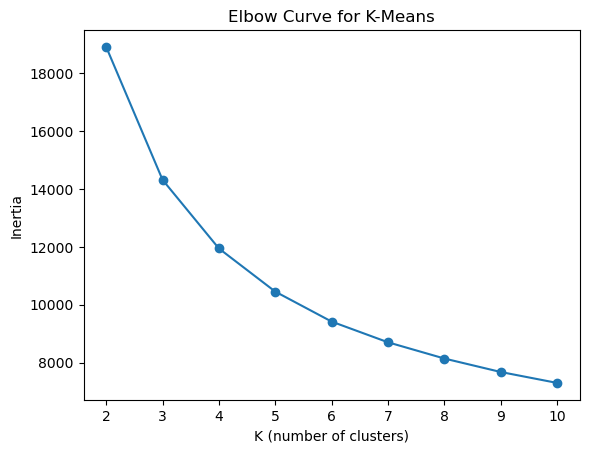

In [12]:

inertias = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X.values)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("K (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Curve for K-Means")
plt.show()


### 6.2 Fit K-Means for best K (choose by visual elbow) & evaluate

In [13]:

# You can adjust best_k after inspecting the elbow plot.
best_k = 4
km_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = km_best.fit_predict(X.values)

sil_kmeans = silhouette_score(X.values, kmeans_labels)
print("K-Means silhouette score:", sil_kmeans)


K-Means silhouette score: 0.3411776895124208


### 6.3 Visualize K-Means clusters in PCA space

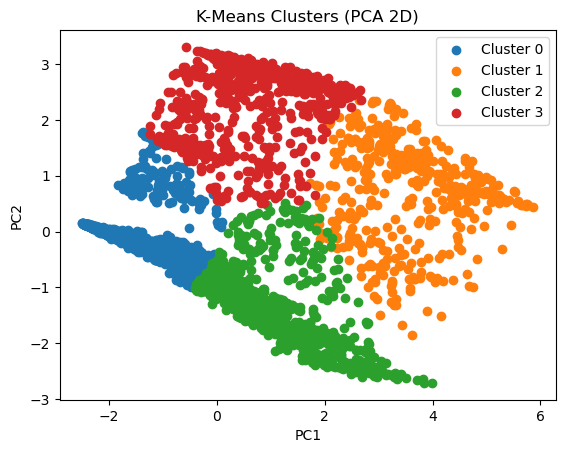

In [14]:

plt.figure()
for lab in np.unique(kmeans_labels):
    idx = np.where(kmeans_labels == lab)[0]
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f"Cluster {lab}")
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## 7) Hierarchical (Agglomerative) Clustering

### 7.1 Dendrogram (using Ward linkage on a sample if large)

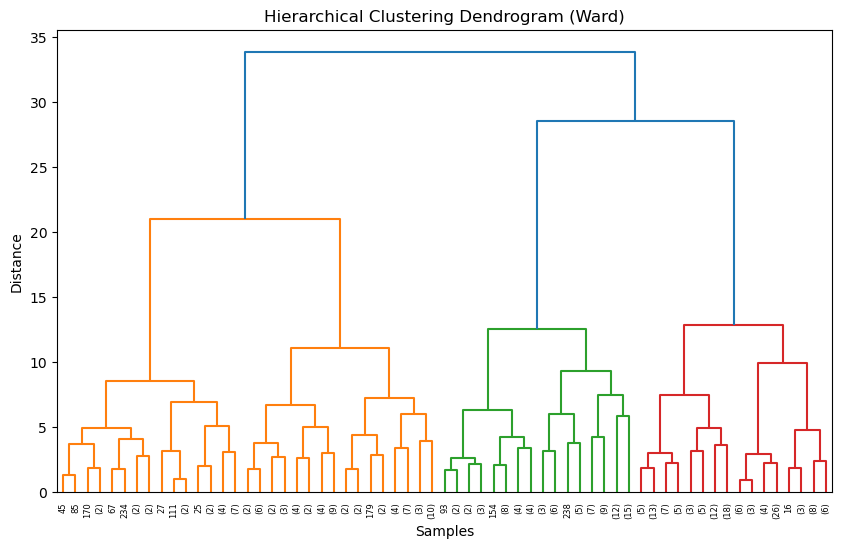

In [15]:

# For dendrogram performance, sample if dataset large
sample_size = min(300, X.shape[0])
np.random.seed(42)
sample_idx = np.random.choice(X.shape[0], size=sample_size, replace=False)
Z = linkage(X.values[sample_idx], method='ward')
plt.figure(figsize=(10,6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


### 7.2 Try different linkage criteria & evaluate

In [16]:

linkages = ['ward', 'complete', 'average', 'single']
results_h = []
for link in linkages:
    if link == 'ward':
        agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
    else:
        agg = AgglomerativeClustering(n_clusters=best_k, linkage=link)
    labels_h = agg.fit_predict(X.values)
    sil = silhouette_score(X.values, labels_h)
    results_h.append((link, sil))

pd.DataFrame(results_h, columns=['linkage', 'silhouette'])


,linkage,silhouette
0,ward,0.270636
1,complete,0.251595
2,average,0.314969
3,single,0.149888


### 7.3 Visualize Hierarchical clusters (best linkage) in PCA space

Best linkage by silhouette: average


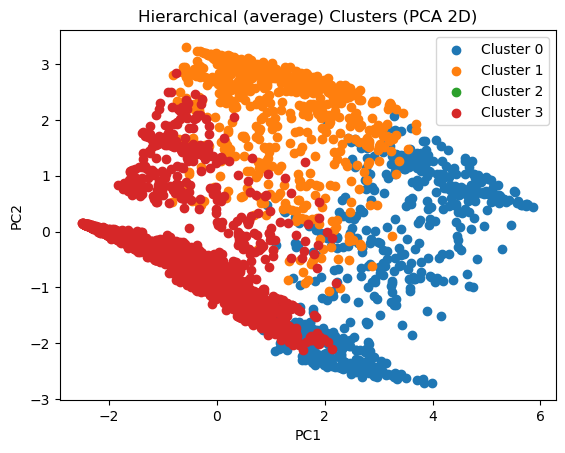

In [17]:

best_linkage = max(results_h, key=lambda x: x[1])[0]
print("Best linkage by silhouette:", best_linkage)

if best_linkage == 'ward':
    agg_best = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
else:
    agg_best = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage)

h_labels = agg_best.fit_predict(X.values)

plt.figure()
for lab in np.unique(h_labels):
    idx = np.where(h_labels == lab)[0]
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f"Cluster {lab}")
plt.title(f"Hierarchical ({best_linkage}) Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## 8) DBSCAN Clustering

### 8.1 Parameter sweep (epsilon, min_samples) & evaluation

In [18]:

eps_values = [0.5, 0.7, 0.9, 1.1, 1.3]
min_samples_values = [3, 5, 8, 10]
results_d = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels_d = db.fit_predict(X.values)
        n_clusters = len(set(labels_d)) - (1 if -1 in labels_d else 0)
        sil = np.nan
        if n_clusters >= 2:
            sil = silhouette_score(X.values, labels_d)
        results_d.append((eps, ms, n_clusters, sil))

df_dbscan = pd.DataFrame(results_d, columns=['eps', 'min_samples', 'n_clusters', 'silhouette'])
df_dbscan.sort_values(['silhouette'], ascending=False, inplace=True, na_position='last')
df_dbscan.head(10)


,eps,min_samples,n_clusters,silhouette
12,1.1,3,7,0.111140
9,0.9,5,10,0.060960
13,1.1,5,2,0.041108
6,0.7,8,15,-0.006940
8,0.9,3,16,-0.009570
5,0.7,5,23,-0.018500
10,0.9,8,10,-0.033149
7,0.7,10,13,-0.043649
4,0.7,3,55,-0.044778
11,0.9,10,9,-0.077057


### 8.2 Fit best DBSCAN and visualize

Best DBSCAN params: 1.1 3
DBSCAN clusters: 7 Silhouette: 0.1111400847877572


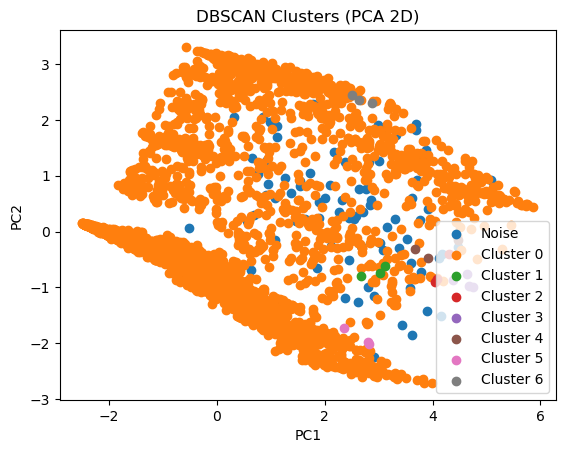

In [21]:

valid = df_dbscan.dropna(subset=['silhouette'])
if not valid.empty:
    best_row = valid.iloc[0]
else:
    tmp = df_dbscan[df_dbscan['n_clusters']>=2]
    best_row = tmp.iloc[0] if not tmp.empty else df_dbscan.iloc[0]

best_eps = float(best_row['eps'])
best_ms = int(best_row['min_samples'])
print("Best DBSCAN params:", best_eps, best_ms)

db_best = DBSCAN(eps=best_eps, min_samples=best_ms)
db_labels = db_best.fit_predict(X.values)

n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
sil_db = np.nan
if n_clusters_db >= 2:
    sil_db = silhouette_score(X.values, db_labels)
print("DBSCAN clusters:", n_clusters_db, "Silhouette:", sil_db)

plt.figure()
unique_labels = sorted(set(db_labels))
for lab in unique_labels:
    idx = np.where(db_labels == lab)[0]
    lbl = "Noise" if lab == -1 else f"Cluster {lab}"
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=lbl)
plt.title("DBSCAN Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## 9) Cluster Profiling

In [20]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_capped)  # X_capped must be numeric array or DataFrame

def profile_clusters(labels, X_capped, original_df, award_col='Award?'):
    prof = pd.DataFrame(X_capped.copy())
    prof['cluster'] = labels
    summary = prof.groupby('cluster').agg(['mean','median','min','max','count'])
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    if award_col in original_df.columns:
        tmp = original_df[[award_col]].copy()
        tmp['cluster'] = labels
        award_dist = tmp.groupby(['cluster', award_col]).size().unstack(fill_value=0)
        return summary, award_dist
    return summary, None

k_profile, k_award = profile_clusters(kmeans_labels, X_capped, df)
h_profile, h_award = profile_clusters(h_labels, X_capped, df)
d_profile, d_award = profile_clusters(db_labels, X_capped, df)

display(k_profile.head())
if k_award is not None:
    display(k_award)

display(h_profile.head())
if h_award is not None:
    display(h_award)

display(d_profile.head())
if d_award is not None:
    display(d_award)


,Balance_mean,Balance_median,Balance_min,Balance_max,Balance_count,Qual_miles_mean,Qual_miles_median,Qual_miles_min,Qual_miles_max,Qual_miles_count,cc1_miles_mean,cc1_miles_median,cc1_miles_min,cc1_miles_max,cc1_miles_count,cc2_miles_mean,cc2_miles_median,cc2_miles_min,cc2_miles_max,cc2_miles_count,cc3_miles_mean,cc3_miles_median,cc3_miles_min,cc3_miles_max,cc3_miles_count,Bonus_miles_mean,Bonus_miles_median,Bonus_miles_min,Bonus_miles_max,Bonus_miles_count,Bonus_trans_mean,Bonus_trans_median,Bonus_trans_min,Bonus_trans_max,Bonus_trans_count,Flight_miles_12mo_mean,Flight_miles_12mo_median,Flight_miles_12mo_min,Flight_miles_12mo_max,Flight_miles_12mo_count,Flight_trans_12_mean,Flight_trans_12_median,Flight_trans_12_min,Flight_trans_12_max,Flight_trans_12_count,Days_since_enroll_mean,Days_since_enroll_median,Days_since_enroll_min,Days_since_enroll_max,Days_since_enroll_count
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,31951.863887,21915.0,50.0,203218.75,1901,0.0,0.0,0.0,0.0,1901,1.132562,1.0,1.0,3.0,1901,1.0,1.0,1.0,1.0,1901,1.0,1.0,1.0,1.0,1901,3455.160442,1500.0,0.0,40256.00,1901,5.937927,4.0,0.0,38.0,1901,12.192530,0.0,0.0,500.0,1901,0.064177,0.0,0.0,2.0,1901,3589.117307,3384.0,2.0,8296.0,1901
1,127277.539773,127787.5,2843.0,203218.75,396,0.0,0.0,0.0,0.0,396,4.055556,4.0,1.0,5.0,396,1.0,1.0,1.0,1.0,396,1.0,1.0,1.0,1.0,396,44729.776515,47567.0,1753.0,57626.25,396,24.851010,23.0,6.0,38.0,396,643.967172,777.5,50.0,777.5,396,2.013889,2.5,1.0,2.5,396,5097.719697,5271.0,542.0,8296.0,396
2,89709.091165,76825.5,329.0,203218.75,1064,0.0,0.0,0.0,0.0,1064,3.475564,3.0,1.0,5.0,1064,1.0,1.0,1.0,1.0,1064,1.0,1.0,1.0,1.0,1064,30501.383694,27188.5,2750.0,57626.25,1064,16.941729,15.0,4.0,38.0,1064,25.212406,0.0,0.0,550.0,1064,0.117481,0.0,0.0,2.0,1064,4715.001880,4765.0,450.0,8296.0,1064
3,75890.129310,55969.5,0.0,203218.75,638,0.0,0.0,0.0,0.0,638,1.221003,1.0,1.0,3.0,638,1.0,1.0,1.0,1.0,638,1.0,1.0,1.0,1.0,638,7668.947100,5000.0,100.0,57626.25,638,10.526646,8.0,1.0,38.0,638,637.977273,777.5,100.0,777.5,638,2.070533,2.5,1.0,2.5,638,4093.648903,4073.0,268.0,8296.0,638


Award?,0,1
cluster,,
0,1542,359
1,94,302
2,559,505
3,323,315


,Balance_mean,Balance_median,Balance_min,Balance_max,Balance_count,Qual_miles_mean,Qual_miles_median,Qual_miles_min,Qual_miles_max,Qual_miles_count,cc1_miles_mean,cc1_miles_median,cc1_miles_min,cc1_miles_max,cc1_miles_count,cc2_miles_mean,cc2_miles_median,cc2_miles_min,cc2_miles_max,cc2_miles_count,cc3_miles_mean,cc3_miles_median,cc3_miles_min,cc3_miles_max,cc3_miles_count,Bonus_miles_mean,Bonus_miles_median,Bonus_miles_min,Bonus_miles_max,Bonus_miles_count,Bonus_trans_mean,Bonus_trans_median,Bonus_trans_min,Bonus_trans_max,Bonus_trans_count,Flight_miles_12mo_mean,Flight_miles_12mo_median,Flight_miles_12mo_min,Flight_miles_12mo_max,Flight_miles_12mo_count,Flight_trans_12_mean,Flight_trans_12_median,Flight_trans_12_min,Flight_trans_12_max,Flight_trans_12_count,Days_since_enroll_mean,Days_since_enroll_median,Days_since_enroll_min,Days_since_enroll_max,Days_since_enroll_count
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,129528.922371,134060.0,2843.0,203218.75,599,0.0,0.0,0.0,0.0,599,4.409015,4.0,2.0,5.0,599,1.0,1.0,1.0,1.0,599,1.0,1.0,1.0,1.0,599,48631.702421,55323.0,10232.0,57626.25,599,22.005008,20.0,6.0,38.0,599,324.941569,200.0,0.0,777.5,599,1.034224,1.0,0.0,2.5,599,5226.689482,5428.0,542.0,8296.0,599
1,85429.328704,70388.0,0.0,203218.75,648,0.0,0.0,0.0,0.0,648,1.637346,1.0,1.0,5.0,648,1.0,1.0,1.0,1.0,648,1.0,1.0,1.0,1.0,648,13406.872685,8435.0,100.0,57626.25,648,13.689815,12.5,1.0,38.0,648,666.655093,777.5,50.0,777.5,648,2.131944,2.5,1.0,2.5,648,4098.734568,4051.0,309.0,8296.0,648
2,61841.000000,61841.0,61841.0,61841.00,1,0.0,0.0,0.0,0.0,1,1.000000,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1,48700.000000,48700.0,48700.0,48700.00,1,38.000000,38.0,38.0,38.0,1,0.000000,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,1659.000000,1659.0,1659.0,1659.0,1
3,44348.565613,30040.0,50.0,203218.75,2751,0.0,0.0,0.0,0.0,2751,1.647764,1.0,1.0,4.0,2751,1.0,1.0,1.0,1.0,2751,1.0,1.0,1.0,1.0,2751,8637.138768,3630.0,0.0,57626.25,2751,8.644493,8.0,0.0,38.0,2751,31.047619,0.0,0.0,777.5,2751,0.132497,0.0,0.0,2.5,2751,3882.840058,3776.0,2.0,8296.0,2751


Award?,0,1
cluster,,
0,206,393
1,280,368
2,0,1
3,2032,719


,Balance_mean,Balance_median,Balance_min,Balance_max,Balance_count,Qual_miles_mean,Qual_miles_median,Qual_miles_min,Qual_miles_max,Qual_miles_count,cc1_miles_mean,cc1_miles_median,cc1_miles_min,cc1_miles_max,cc1_miles_count,cc2_miles_mean,cc2_miles_median,cc2_miles_min,cc2_miles_max,cc2_miles_count,cc3_miles_mean,cc3_miles_median,cc3_miles_min,cc3_miles_max,cc3_miles_count,Bonus_miles_mean,Bonus_miles_median,Bonus_miles_min,Bonus_miles_max,Bonus_miles_count,Bonus_trans_mean,Bonus_trans_median,Bonus_trans_min,Bonus_trans_max,Bonus_trans_count,Flight_miles_12mo_mean,Flight_miles_12mo_median,Flight_miles_12mo_min,Flight_miles_12mo_max,Flight_miles_12mo_count,Flight_trans_12_mean,Flight_trans_12_median,Flight_trans_12_min,Flight_trans_12_max,Flight_trans_12_count,Days_since_enroll_mean,Days_since_enroll_median,Days_since_enroll_min,Days_since_enroll_max,Days_since_enroll_count
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,63768.635784,43097.0,0.0,203218.75,3999,0.0,0.0,0.0,0.0,3999,2.059515,1.0,1.0,5.0,3999,1.0,1.0,1.0,1.0,3999,1.0,1.0,1.0,1.0,3999,15410.730683,7171.0,0.0,57626.25,3999,11.470618,12.0,0.0,38.0,3999,178.055639,0.0,0.0,777.5,3999,0.591523,0.0,0.0,2.5,3999,4118.55939,4096.0,2.0,8296.0,3999


Award?,0,1
cluster,,
-1,2518,1481
